In [76]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [77]:
# Load data
df = pd.read_csv('Full-EEG.csv')
X = df.drop(columns=['Target'])  # Features
Y = df['Target']  # Target variable

In [78]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [79]:
# Initialize DataFrame to store results
metrics_df = pd.DataFrame(columns=[
    'Algorithm', 'Accuracy', 'Sensitivity', 'Specificity', 'MSR', 'GMean', 'FPR', 'Error Rate', 'Precision'
])

In [80]:
def calculate_metrics(y_true, y_pred_binary, mse):
    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    accuracy = accuracy_score(y_true, y_pred_binary)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    gmean = np.sqrt(sensitivity * specificity)
    fpr = fp / (fp + tn)
    error_rate = 1 - accuracy
    precision = precision_score(y_true, y_pred_binary)
    return accuracy, sensitivity, specificity, mse, gmean, fpr, error_rate, precision


In [81]:
# 1. Linear Regression
Lin_reg = LinearRegression()
Lin_reg.fit(X_train, y_train)
y_pred = Lin_reg.predict(X_test)


In [82]:
# Convert continuous predictions to binary for classification metrics
y_pred_binary = np.round(y_pred).astype(int)

In [83]:
# Calculate Mean Squared Error (MSR) and other metrics
mse = mean_squared_error(y_test, y_pred)
metrics = calculate_metrics(y_test, y_pred_binary, mse)

In [84]:
# Store metrics in DataFrame
metrics_df.loc[len(metrics_df)] = ['Linear Regression'] + list(metrics)

In [85]:
print(metrics_df)

           Algorithm  Accuracy  Sensitivity  Specificity       MSR     GMean  \
0  Linear Regression  0.893204     0.909091     0.881356  0.080588  0.895116   

        FPR  Error Rate  Precision  
0  0.118644    0.106796   0.851064  


In [86]:
# 2. Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Calculate MSR (using mean squared error for comparison) and other metrics
mse = mean_squared_error(y_test, y_pred)
metrics = calculate_metrics(y_test, y_pred, mse)
metrics_df.loc[len(metrics_df)] = ['Logistic Regression'] + list(metrics)

In [87]:
print(metrics_df)

             Algorithm  Accuracy  Sensitivity  Specificity       MSR  \
0    Linear Regression  0.893204     0.909091     0.881356  0.080588   
1  Logistic Regression  0.980583     0.954545     1.000000  0.019417   

      GMean       FPR  Error Rate  Precision  
0  0.895116  0.118644    0.106796   0.851064  
1  0.977008  0.000000    0.019417   1.000000  


In [88]:
# 3. Non-Linear Regression (Polynomial Regression with degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred = poly_reg.predict(X_test_poly)

# Convert continuous predictions to binary for classification metrics
y_pred_binary = np.round(y_pred).astype(int)

# Calculate MSR and other metrics
mse = mean_squared_error(y_test, y_pred)
metrics = calculate_metrics(y_test, y_pred_binary, mse)
metrics_df.loc[len(metrics_df)] = ['Non-Linear Regression (Polynomial)'] + list(metrics)

In [89]:
print(metrics_df)

                            Algorithm  Accuracy  Sensitivity  Specificity  \
0                   Linear Regression  0.893204     0.909091     0.881356   
1                 Logistic Regression  0.980583     0.954545     1.000000   
2  Non-Linear Regression (Polynomial)  1.000000     1.000000     1.000000   

        MSR     GMean       FPR  Error Rate  Precision  
0  0.080588  0.895116  0.118644    0.106796   0.851064  
1  0.019417  0.977008  0.000000    0.019417   1.000000  
2  0.017299  1.000000  0.000000    0.000000   1.000000  


In [90]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_train)
y_pred_train = gmm.predict(X_train)
y_pred_test = gmm.predict(X_test)

from scipy.stats import mode
mapping = {}
for i in range(2):
    cluster_indices = (y_pred_train == i)
    if cluster_indices.any():  # Check if there are any samples in the cluster
        cluster_mode = mode(y_train[cluster_indices], keepdims=True)
        mapping[i] = cluster_mode.mode[0]  # Access mode value safely
    else:
        mapping[i] = 0  # Default if no samples are in the cluster

# Map predictions for test set based on the derived mapping
y_pred_mapped = np.vectorize(mapping.get)(y_pred_test)

# Calculate MSR (using mean squared error for comparison) and other metrics
mse = mean_squared_error(y_test, y_pred_mapped)
metrics = calculate_metrics(y_test, y_pred_mapped, mse)
metrics_df.loc[len(metrics_df)] = ['GMM (EM)'] + list(metrics)

In [91]:
# Save the metrics to a CSV file
metrics_df.to_csv('without_firefly_model_metrics.csv', index=False)
print("Metrics saved to 'model_metrics.csv'")

Metrics saved to 'model_metrics.csv'


In [92]:
print(metrics_df)

                            Algorithm  Accuracy  Sensitivity  Specificity  \
0                   Linear Regression  0.893204     0.909091     0.881356   
1                 Logistic Regression  0.980583     0.954545     1.000000   
2  Non-Linear Regression (Polynomial)  1.000000     1.000000     1.000000   
3                            GMM (EM)  0.825243     1.000000     0.694915   

        MSR     GMean       FPR  Error Rate  Precision  
0  0.080588  0.895116  0.118644    0.106796   0.851064  
1  0.019417  0.977008  0.000000    0.019417   1.000000  
2  0.017299  1.000000  0.000000    0.000000   1.000000  
3  0.174757  0.833616  0.305085    0.174757   0.709677  


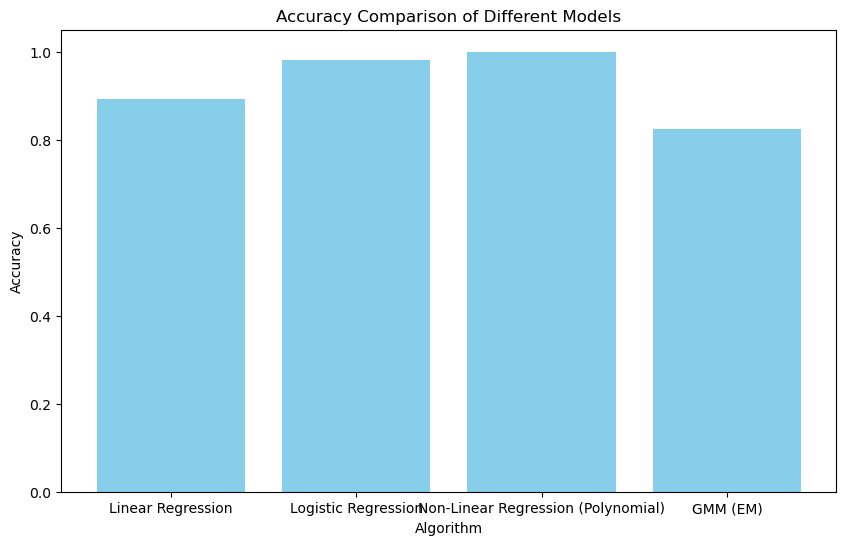

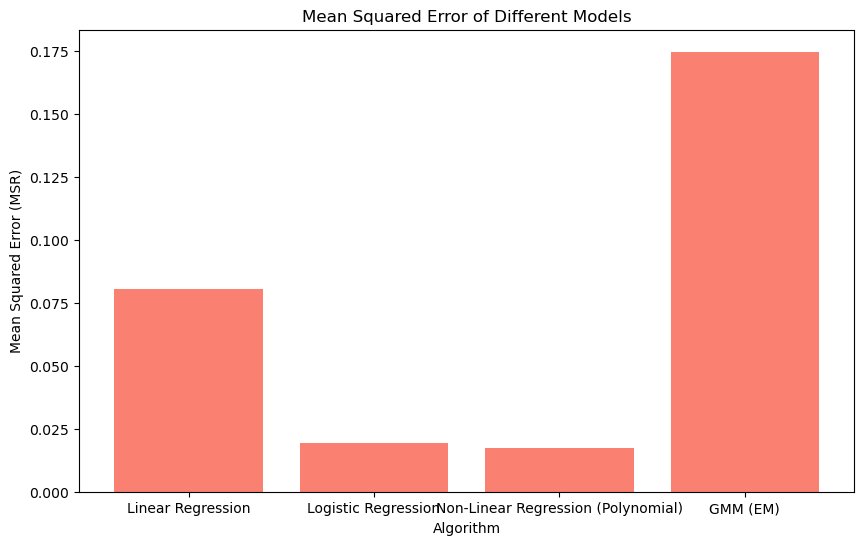

In [93]:
# Plotting Accuracy and MSR
plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Algorithm'], metrics_df['Accuracy'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_df['Algorithm'], metrics_df['MSR'], color='salmon')
plt.xlabel('Algorithm')
plt.ylabel('Mean Squared Error (MSR)')
plt.title('Mean Squared Error of Different Models')
plt.show()